## Interval Analysis

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1) # added softmax for probabilities
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()


Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [2]:
def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [3]:
train_model(model, 15)
test_model(model)

Epoch 1/15, Loss: 2.012
Epoch 2/15, Loss: 1.729
Epoch 3/15, Loss: 1.627
Epoch 4/15, Loss: 1.596
Epoch 5/15, Loss: 1.582
Epoch 6/15, Loss: 1.572
Epoch 7/15, Loss: 1.566
Epoch 8/15, Loss: 1.561
Epoch 9/15, Loss: 1.557
Epoch 10/15, Loss: 1.553
Epoch 11/15, Loss: 1.550
Epoch 12/15, Loss: 1.547
Epoch 13/15, Loss: 1.545
Epoch 14/15, Loss: 1.542
Epoch 15/15, Loss: 1.540
Accuracy on images: 93.43


### Write the interval analysis for the simple model

In [4]:
## Interval Analysis Implementation

class IntervalBounds:
    """Class to represent interval bounds [lower, upper]"""
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

def interval_linear(W, b, x_interval):
    """Propagate intervals through a linear layer"""
    # For y = Wx + b with W shape [out_features, in_features] and x shape [batch, in_features]
    
    W_pos = torch.clamp(W, min=0)
    W_neg = torch.clamp(W, max=0)
    
    # Compute bounds: input @ W.T + b
    lower = x_interval.lower @ W_pos.T + x_interval.upper @ W_neg.T + b
    upper = x_interval.upper @ W_pos.T + x_interval.lower @ W_neg.T + b
    
    return IntervalBounds(lower, upper)

def interval_relu(x_interval):
    """Propagate intervals through ReLU activation"""
    lower = torch.clamp(x_interval.lower, min=0)
    upper = torch.clamp(x_interval.upper, min=0)
    return IntervalBounds(lower, upper)

def interval_normalize(x_interval, mean=0.1307, std=0.3081):
    """Propagate intervals through normalization"""
    lower = (x_interval.lower - mean) / std
    upper = (x_interval.upper - mean) / std
    return IntervalBounds(lower, upper)

def propagate_intervals(model, x_lower, x_upper):
    """Propagate interval bounds through the entire network"""
    # Create initial interval
    x_interval = IntervalBounds(x_lower, x_upper)
    
    # Get model parameters
    normalize_layer = model[0]
    net = model[1]
    
    # Normalize
    x_interval = interval_normalize(x_interval)
    
    # Flatten
    x_interval.lower = x_interval.lower.view(-1, 28*28)
    x_interval.upper = x_interval.upper.view(-1, 28*28)
    
    # First linear layer
    W1 = net.fc.weight.data
    b1 = net.fc.bias.data
    x_interval = interval_linear(W1, b1, x_interval)
    
    # ReLU
    x_interval = interval_relu(x_interval)
    
    # Second linear layer
    W2 = net.fc2.weight.data
    b2 = net.fc2.bias.data
    x_interval = interval_linear(W2, b2, x_interval)
    
    return x_interval.lower, x_interval.upper

def verify_robustness(model, image, label, epsilon):
    """Verify if the model is robust for a given epsilon"""
    # Create perturbed input bounds (L-infinity ball)
    x_lower = torch.clamp(image - epsilon, min=0.0, max=1.0)
    x_upper = torch.clamp(image + epsilon, min=0.0, max=1.0)
    
    # Propagate intervals
    output_lower, output_upper = propagate_intervals(model, x_lower, x_upper)
    
    # Check if the correct class is always the maximum
    # For verification: lower bound of correct class > upper bound of all other classes
    correct_class_lower = output_lower[0, label]
    
    # Get upper bounds of all other classes
    other_classes_upper = torch.cat([
        output_upper[0, :label],
        output_upper[0, label+1:]
    ])
    
    max_other_upper = torch.max(other_classes_upper)
    
    # Verification succeeds if correct class lower bound > all other upper bounds
    verified = correct_class_lower > max_other_upper
    
    return verified.item()

def compute_verified_accuracy(model, epsilon):
    """Compute verified accuracy for a given epsilon"""
    model.eval()
    verified_count = 0
    total_count = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Only verify correctly classified images
            for i in range(len(images)):
                if predicted[i] == labels[i]:
                    if verify_robustness(model, images[i:i+1], labels[i], epsilon):
                        verified_count += 1
                total_count += 1
    
    verified_accuracy = 100 * verified_count / total_count
    return verified_accuracy

# Test for 10 epsilon values between 0.01 and 0.1
epsilons = np.linspace(0.01, 0.1, 10)
verified_accuracies = []

print("\nComputing verified accuracies for different epsilon values...")
print("="*60)

for eps in epsilons:
    print(f"\nTesting epsilon = {eps:.3f}...")
    start_time = time.time()
    verified_acc = compute_verified_accuracy(model, eps)
    elapsed_time = time.time() - start_time
    verified_accuracies.append(verified_acc)
    print(f"Epsilon: {eps:.3f} | Verified Accuracy: {verified_acc:.2f}% | Time: {elapsed_time:.2f}s")

print("\n" + "="*60)
print("Summary of Results:")
print("="*60)
for eps, acc in zip(epsilons, verified_accuracies):
    print(f"ε = {eps:.3f}: {acc:.2f}% verified")


Computing verified accuracies for different epsilon values...

Testing epsilon = 0.010...
Epsilon: 0.010 | Verified Accuracy: 49.59% | Time: 3.95s

Testing epsilon = 0.020...
Epsilon: 0.020 | Verified Accuracy: 5.30% | Time: 3.93s

Testing epsilon = 0.030...
Epsilon: 0.030 | Verified Accuracy: 0.20% | Time: 3.96s

Testing epsilon = 0.040...
Epsilon: 0.040 | Verified Accuracy: 0.00% | Time: 3.99s

Testing epsilon = 0.050...
Epsilon: 0.050 | Verified Accuracy: 0.00% | Time: 4.01s

Testing epsilon = 0.060...
Epsilon: 0.060 | Verified Accuracy: 0.00% | Time: 4.01s

Testing epsilon = 0.070...
Epsilon: 0.070 | Verified Accuracy: 0.00% | Time: 4.04s

Testing epsilon = 0.080...
Epsilon: 0.080 | Verified Accuracy: 0.00% | Time: 4.13s

Testing epsilon = 0.090...
Epsilon: 0.090 | Verified Accuracy: 0.00% | Time: 4.12s

Testing epsilon = 0.100...
Epsilon: 0.100 | Verified Accuracy: 0.00% | Time: 4.11s

Summary of Results:
ε = 0.010: 49.59% verified
ε = 0.020: 5.30% verified
ε = 0.030: 0.20% verif

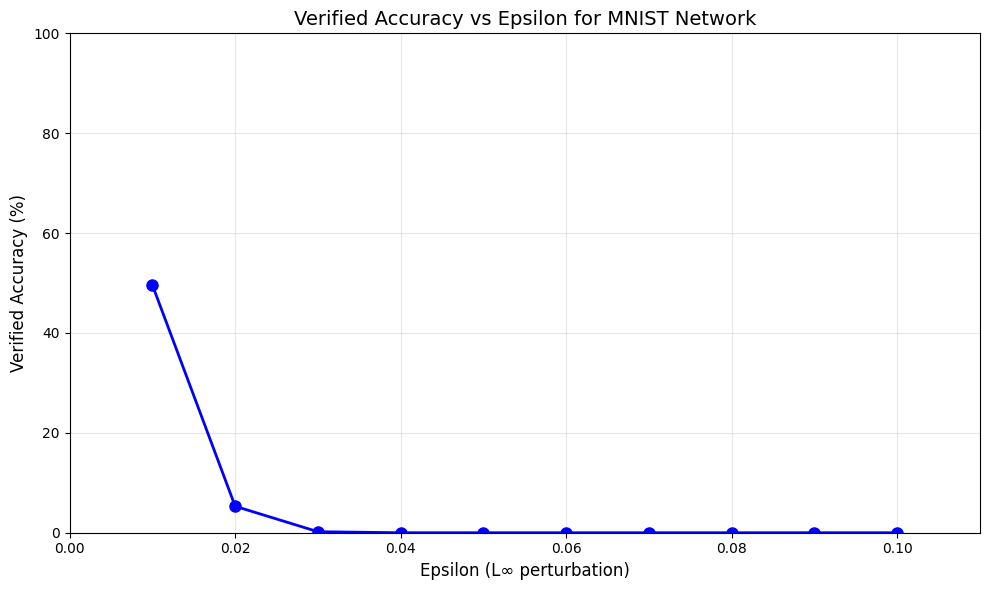


Observations:
------------------------------------------------------------
1. At ε = 0.010, verified accuracy: 49.59%
2. At ε = 0.100, verified accuracy: 0.00%
3. Accuracy drop: 49.59%

4. As epsilon increases, verified accuracy decreases, showing that
   larger perturbations make it harder to guarantee robustness.

5. The interval analysis provides a sound but conservative estimate,
   meaning the actual robustness might be higher than reported.


In [5]:
# Visualization of results
plt.figure(figsize=(10, 6))
plt.plot(epsilons, verified_accuracies, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Epsilon (L∞ perturbation)', fontsize=12)
plt.ylabel('Verified Accuracy (%)', fontsize=12)
plt.title('Verified Accuracy vs Epsilon for MNIST Network', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.11)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Print observations
print("\nObservations:")
print("-" * 60)
print(f"1. At ε = {epsilons[0]:.3f}, verified accuracy: {verified_accuracies[0]:.2f}%")
print(f"2. At ε = {epsilons[-1]:.3f}, verified accuracy: {verified_accuracies[-1]:.2f}%")
print(f"3. Accuracy drop: {verified_accuracies[0] - verified_accuracies[-1]:.2f}%")
print("\n4. As epsilon increases, verified accuracy decreases, showing that")
print("   larger perturbations make it harder to guarantee robustness.")
print("\n5. The interval analysis provides a sound but conservative estimate,")
print("   meaning the actual robustness might be higher than reported.")